---
# Task 3 - Network Analysis

## Imports and Settings

In [1]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Imports
import os
import sys
import time
import warnings
from collections import defaultdict
from ipywidgets import widgets, Layout
from IPython.display import display
from IPython.display import Markdown as md

import numpy as np
import pandas as pd

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import networkx as nx

In [2]:
# Matplotlib Settings
plt.style.use(["seaborn-ticks"])
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.which"] = "both"
plt.rcParams["grid.linestyle"] = "--"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["figure.figsize"] = (7.5, 5)
plt.rcParams["figure.dpi"] = 150
plt.rcParams["figure.autolayout"] = True
plt.rcParams["legend.fancybox"] = True
plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.loc"] = "best"
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.titlesize"] = "x-large"
sns.set(rc=dict(plt.rcParams))


## Reading Data

**Implementation Details**
1. Open the data file using inbuilt `open` function.
1. Create a set of edges.
1. Use the list to create a `Graph` object for further analysis.

**Preprocessing for List of Edges**
1. Convert str to int.
1. Sort each of the edges to easily identify duplicates.
1. Save as set to automatically remove duplicates.

In [3]:
# Convert str to int
str_to_int = lambda x: map(int, x)

# Convert type, sort the list and save as tuple
preprocess_edge_list = lambda x: map(lambda i: tuple(sorted(str_to_int(i))), x)

with open("data/social-network.csv", "r") as f:
    edge_list = [line.split(",") for line in f]  # Get list of edges 
    
    # Preprocess the edges and save as set to remove duplicates
    edge_list = set(preprocess_edge_list(edge_list))
    
    nx_graph = nx.from_edgelist(edge_list)       # Create Graph object
    del edge_list                                # Delete edge_list for memory
    
print(f"Number of edges: {nx_graph.number_of_edges()}")
print(f"Number of nodes: {nx_graph.number_of_nodes()}")

Number of edges: 2981
Number of nodes: 2888


## Statistics

### Degree
- The degree of a node in a network is the number of edges the node has connected to it.
- By visualising the distribution of degrees of each node, we can get an idea of how connected the network is.

#### Implementation Details

**Degree Statistics**
- We create a DataFrame containing all the nodes in the network and it's respective degree. 
- We calculate the frequency and unique values of degrees by using the `value_counts()` method on the `Degree` column.

**Visualisation**
- We generate a degree distribution using `nx.degree_histogram` builtin function from the `networkx` module.
- Since the frequency of the degrees for the given data varies from 0-2970, we visualise the distribution by applying a `log10` transform to the frequency axis.

Frequency of Degree:
1      2790
2        82
3         3
4         3
55        1
58        1
97        1
139       1
170       1
221       1
287       1
481       1
710       1
769       1
Name: Degree, dtype: int64

Some Highly Connected Nodes: 
Node   603 is highly connected with a maximum degree of  769
Node  1525 is highly connected with a maximum degree of  710
Node   288 is highly connected with a maximum degree of  481
Node     1 is highly connected with a maximum degree of  287
Node   710 is highly connected with a maximum degree of  221
Node  2687 is highly connected with a maximum degree of  170
Node   714 is highly connected with a maximum degree of  139


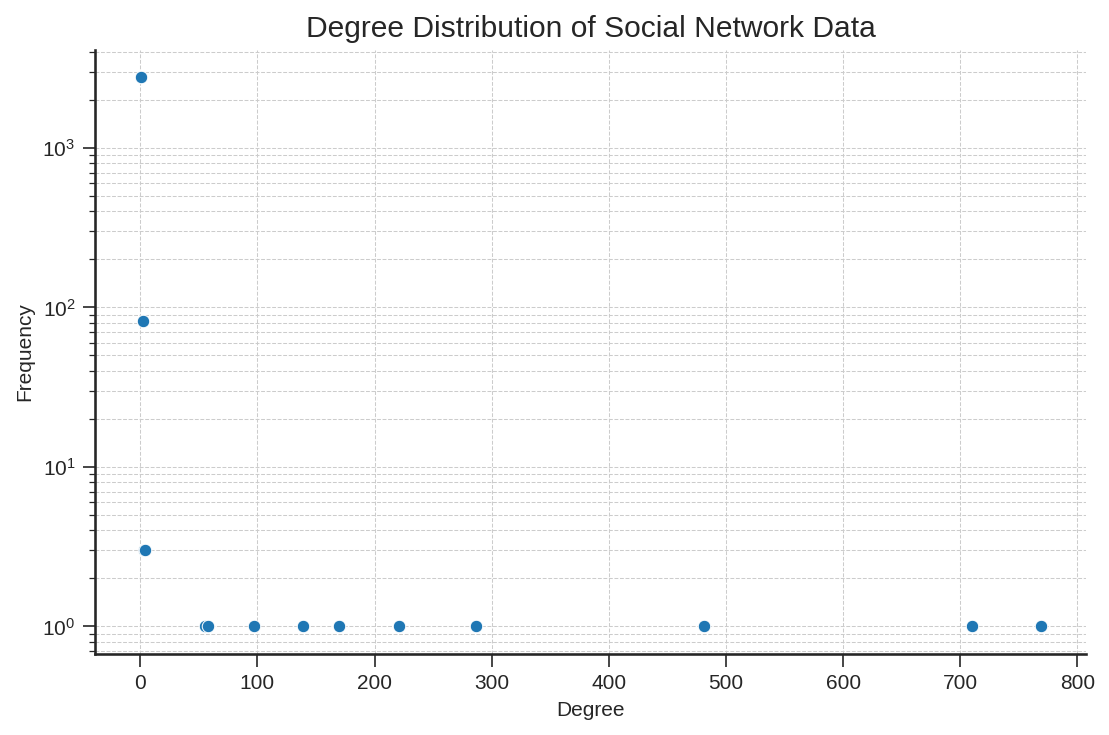

In [4]:
# Create DF of each node and its degree
node_deg_df = pd.DataFrame(
    sorted(nx_graph.degree(), key=lambda x: x[1], reverse=True),
    columns=["Node", "Degree"],
)
print("Frequency of Degree:")
print(node_deg_df["Degree"].value_counts().sort_index(ascending=True))

print("\nSome Highly Connected Nodes: ")
for deg in node_deg_df['Degree'].loc[node_deg_df['Degree'] > 100]:
    print(
        "Node {: 5d} is highly connected with a maximum degree of {: 4d}".format(
            node_deg_df.loc[node_deg_df["Degree"] == deg, "Node"].values[0], deg
        )
    )

# Degree distribution
ddist = nx.degree_histogram(nx_graph)
sctr_plt = sns.scatterplot(x=range(len(ddist)), y=ddist, marker="o")
sctr_plt.set(yscale="log")
plt.title("Degree Distribution of Social Network Data")
plt.ylabel("Frequency")
plt.xlabel("Degree");

#### Analysis
- There are no 0 degree nodes.
- There are many leaf nodes in the network (1 degree nodes)
- There are 7 highly connected nodes with a degree > 100.
- Given above data, it can be hypothesised that most of the edges are towards leaf nodes from the highly connected nodes.

### Connected components
- Set of nodes from which it is possible to reach all other nodes in the set.
- This gives an idea of the most important nodes in the network.
- If there are multiple connected components, the network is disjointed.

#### Implementation Details
- `networkx` module has an inbuilit function `number_connected_components` for the that gives us this statistic.

In [5]:
print("Number of Components: {}".format(nx.number_connected_components(nx_graph)))

Number of Components: 1


#### Analysis
- Thus we can see that the network is not disjointed.

### Diameter

- Gives the shortest path between the most distanced nodes.
- Largest number of nodes which must be tracersed in order to travel from one node to another without backtracking, looping.

#### Implementation
- We can the `networkx` module's inbuilt function `diameter` to calculate the diameter of the graph. 

In [6]:
print("Diameter of the graph: {}".format(nx.diameter(nx_graph)))

Diameter of the graph: 9


### Clustering Coefficient
- Measure of interconnectedness of the neighbours
- Average the score of all nodes to get the network clustering coefficient.
- Given $E_N$ total number of edges between neighbours of the node and $k$ is the number of neighbours, the Clustering Coefficient of the node is calculated as --

$$
C = \frac{2E_N}{k(k-1)}
$$

- Social networks tend to create tightly knit groups characterised by a relatively high density of ties. Hence clustering coefficient is a good statistic to understand how closely knit a particular social network is.

#### Implementation Details

- `networkx` module has an inbuilit function `clustering` for the that gives us this statistic.

Network Average Clustering Coefficient: 0.02725


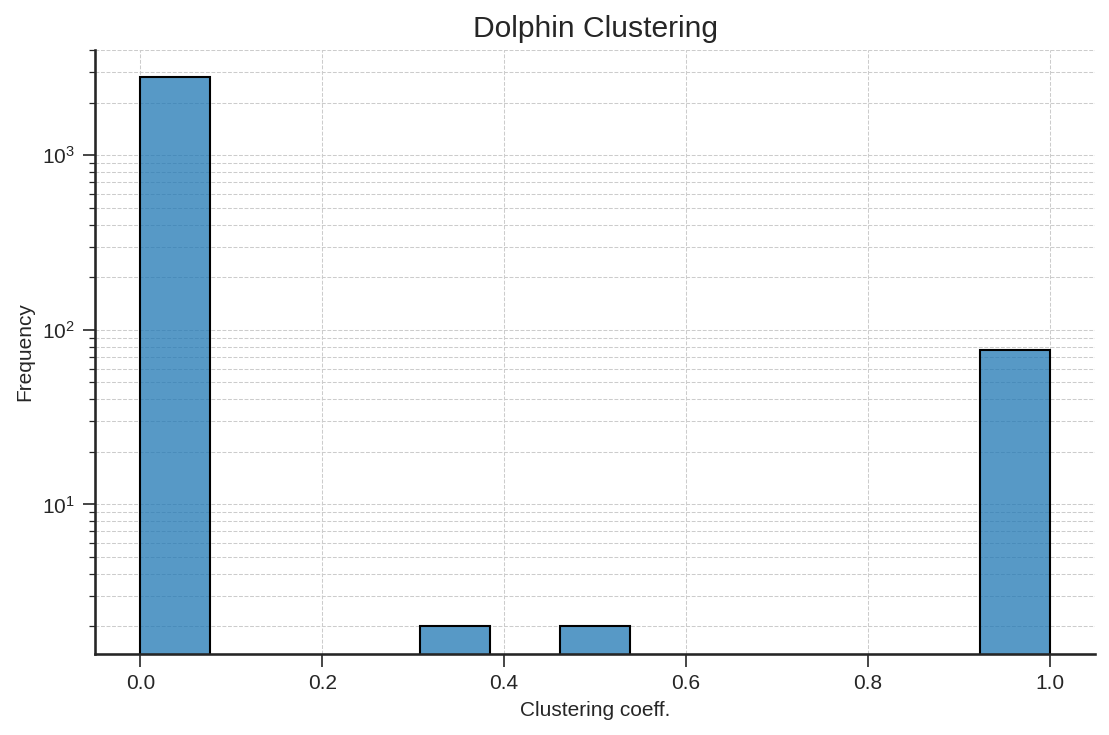

In [7]:
cluster_coeff = nx.clustering(nx_graph)

print(
    "Network Average Clustering Coefficient: {:.5f}".format(
        np.mean(list(cluster_coeff.values()))
    )
)

clust_plt = sns.histplot(x=list(cluster_coeff.values()), bins="auto")
clust_plt.set(yscale="log")
plt.title("Dolphin Clustering")
plt.ylabel("Frequency")
plt.xlabel("Clustering coeff.");


### Betweeness Centrality
- Importance of a node in terms of possible paths through the network
- It is calculated as the fraction of all shortest paths in the network that pass through a node.
- This is important to identify nodes that act as brigdes between separate regions of the network.

#### Implementation Details
- `networkx` module has an inbuilit function `betweenness_centrality` for the that gives us this statistic.

In [8]:
bw_cent = nx.betweenness_centrality(nx_graph)
bw_cent = dict(sorted(bw_cent.items(), key=lambda kv: kv[1], reverse=True))
bw_cent = {node: bnc for node, bnc in bw_cent.items() if bnc > 0.15}

for node, bnc in bw_cent.items():
    print("Node {: 5d} has betweenness Centrality of {:.5f}".format(node, bnc))

Node   603 has betweenness Centrality of 0.54971
Node   288 has betweenness Centrality of 0.46613
Node  1525 has betweenness Centrality of 0.42945
Node   247 has betweenness Centrality of 0.24124
Node     1 has betweenness Centrality of 0.18610


#### Analysis
- We choose a betweeness score of 0.15 as the threshold for a node to be an important central node.
- 5 nodes in the network have a betweeness centrality of more than 0.15 and are considered to be important nodes.

### Assortavity
- Measure of strength of the tendency for nodes to interact with similar other ones.
- Positive values indicate relationships between nodes of similar degrees.
- Negative values indicate relationships between nodes of different degrees.

#### Implementation Details
- `networkx` module has an inbuilit function `degree_assortativity_coefficient` for the that gives us this statistic.

In [9]:
assort_coeff = nx.degree_assortativity_coefficient(nx_graph)
print("The assortavity coefficient of the given network is: {:.5f}".format(assort_coeff))

The assortavity coefficient of the given network is: -0.66821


#### Analysis
- The assortavity coefficient is negative.
- This was expected given the number of leaf nodes. 

## Visualisation

### Implementation Details
- For easier visualisation, we take 100 of the leaf nodes from the graph. This way the shape of the graph is still somewhat maintained while increasing visibility.
- Collect the leaf nodes into a list.
- Shuffle and take the first half of the list as the set to be kept.
- We do not fix the seed here, so as to randomise the nodes kept in the plot and 

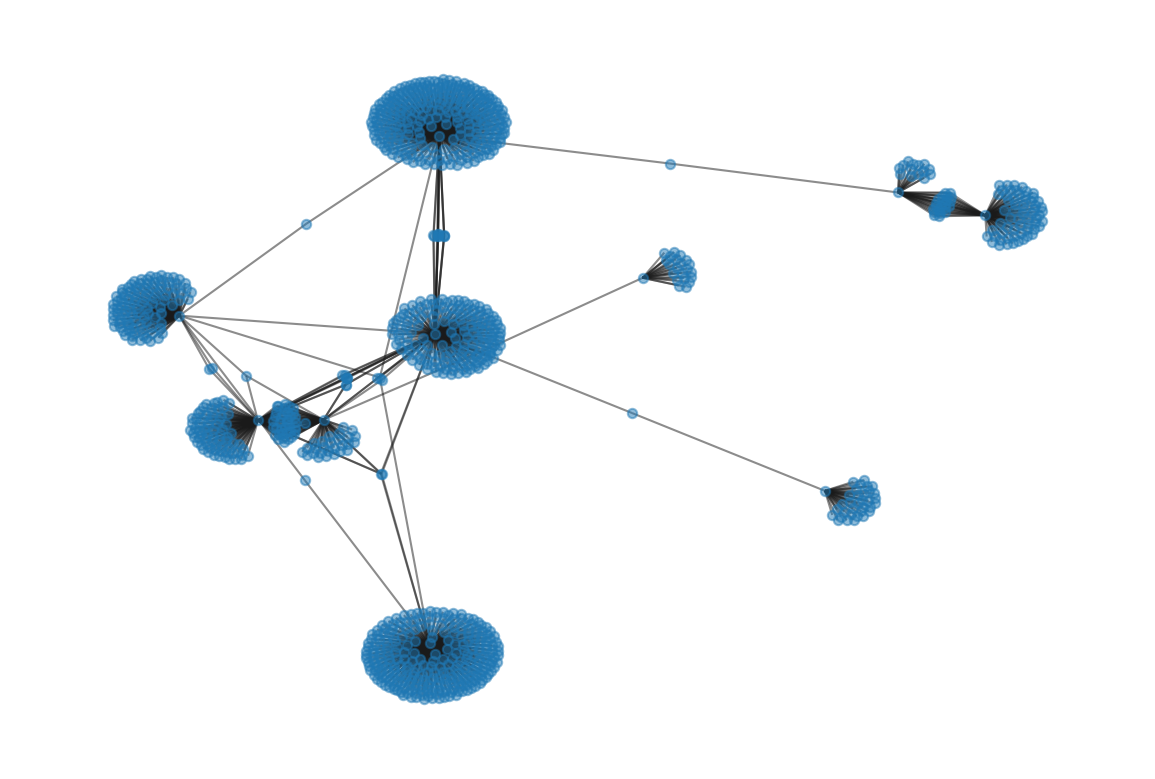

In [23]:
import random

# Get leaf nodes
leaf_nodes = list(node_deg_df.loc[node_deg_df['Degree'] == 1, 'Node'])

# Shuffle and remove nodes
random.shuffle(leaf_nodes)
leaf_nodes_to_remove = leaf_nodes[:-1000]
nx_graph1 = nx_graph.copy()
nx_graph1.remove_nodes_from(leaf_nodes_to_remove)

# Plot the graph
layout = nx.spring_layout(nx_graph1)
nx.draw(nx_graph1, pos=layout, alpha=0.5, node_size=20)

## Conclusions and Learnings

### Conclusions
1. Using information gathered till now, the network can be roughly visualised in the shape of a centipede with central nodes as the body and the leaf nodes as the legs.
1. Most of the nodes are leaf nodes in the graph.
1. The network is not joint and whole.
1. The leaf nodes are connected to a single nearby node and thus form clusters in the network. 
1. There are few highly central and important nodes that keep the network together.


### Learnings
1. Learned network analysis using networkx library
1. Learned to identify important nodes in a graph using statistcs like betweenness centrality.
1. Learned how to visualise networks efficiently

In [ ]:
# If facing with memory issues run this cell!

# WARNING: 
# This will effectively reset the jupyter notebook and erase all variables
# and has been provided to refresh the notebook between different tasks.

%reset -f